In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 37)
(148884, 8)


In [6]:
%store -r model_fl_x
%store -r model_fl_y
%store -r model_fr_x
%store -r model_fr_y
%store -r model_rl_x
%store -r model_rl_y
%store -r model_rr_x
%store -r model_rr_y
%store -r model_fl_com_x
%store -r model_fl_com_y
%store -r model_fr_com_x
%store -r model_fr_com_y

# Foot prediction test

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [7]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score, cross_val_predict

## Test Foot Models

In [8]:
X_motion_step[1, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.35253631e-02, -5.45018454e-03,
        1.90322078e-37, -5.57888703e-24, -4.46281599e-23,  9.45164094e-02,
        1.59093827e-01,  1.32301375e-01, -3.42030436e-01,  2.06204250e-01,
       -1.36616319e-01, -3.38554084e-01, -2.68098682e-01,  1.39270037e-01,
       -3.41048896e-01, -2.74800837e-01, -1.31081313e-01, -3.37453157e-01,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.58638060e-02, -4.57940996e-03,  2.44542360e-02,  1.46174431e-03,
        0.00000000e+00,  0.00000000e+00,  1.09132966e-01,  3.01721154e-03,
        3.34074736e-01])

In [9]:
Y_motion_step[1, :]

array([ 0.07464571, -0.00153224,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03709272, -0.01009694])

In [10]:
min(Y_motion_step[np.where(X_motion_step[:, 1] > 0)[0], 5])

0.0

In [11]:
Y_motion_step[np.where(X_motion_step[:, 24] == 1)[0][:20], 3]

array([-0.00457941,  0.0040237 ,  0.00552526,  0.00480825,  0.00888479,
        0.00985001,  0.00600404,  0.00918202,  0.00653468,  0.00955936,
        0.009455  ,  0.00937624,  0.00945383,  0.00561441,  0.01031588,
        0.01084518,  0.00587085,  0.00323692,  0.00665227,  0.00956017])

In [13]:
# idx to use based on which foot is swinging
X_FR_RL_SWINGING = X_motion_step[np.where(X_motion_step[:, 24] == 1)[0]]
X_FL_RR_SWINGING = X_motion_step[np.where(X_motion_step[:, 25] == 1)[0]]
Y_FR_RL_SWINGING = Y_motion_step[np.where(X_motion_step[:, 24] == 1)[0]]
Y_FL_RR_SWINGING = Y_motion_step[np.where(X_motion_step[:, 25] == 1)[0]]

# INPUT FOR PREDICTION
#FL_X_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 12]]).T, np.array([X_motion_step[:, 15]]).T))
#FL_Y_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 13]]).T, np.array([X_motion_step[:, 16]]).T))
#FR_X_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 12]]).T, np.array([X_motion_step[:, 15]]).T))
#FR_Y_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 13]]).T, np.array([X_motion_step[:, 16]]).T))
#RL_X_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 18]]).T, np.array([X_motion_step[:, 21]]).T))
#RL_Y_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 19]]).T, np.array([X_motion_step[:, 22]]).T))
#RR_X_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 18]]).T, np.array([X_motion_step[:, 21]]).T))
#RR_Y_INPUT = np.hstack((X_motion_step[:, :2], np.array([X_motion_step[:, 5]]).T, X_motion_step[:, 6:8], np.array([X_motion_step[:, 11]]).T, np.array([X_motion_step[:, 19]]).T, np.array([X_motion_step[:, 22]]).T))
FL_X_INPUT = np.hstack((X_FL_RR_SWINGING[:, :2], np.array([X_FL_RR_SWINGING[:, 5]]).T, np.array([X_FL_RR_SWINGING[:, 12]]).T, np.array([X_FL_RR_SWINGING[:, 15]]).T))
FL_Y_INPUT = np.hstack((X_FL_RR_SWINGING[:, :2], np.array([X_FL_RR_SWINGING[:, 5]]).T, np.array([X_FL_RR_SWINGING[:, 13]]).T, np.array([X_FL_RR_SWINGING[:, 16]]).T))
FR_X_INPUT = np.hstack((X_FR_RL_SWINGING[:, :2], np.array([X_FR_RL_SWINGING[:, 5]]).T, np.array([X_FR_RL_SWINGING[:, 12]]).T, np.array([X_FR_RL_SWINGING[:, 15]]).T))
FR_Y_INPUT = np.hstack((X_FR_RL_SWINGING[:, :2], np.array([X_FR_RL_SWINGING[:, 5]]).T, np.array([X_FR_RL_SWINGING[:, 13]]).T, np.array([X_FR_RL_SWINGING[:, 16]]).T))
RL_X_INPUT = np.hstack((X_FR_RL_SWINGING[:, :2], np.array([X_FR_RL_SWINGING[:, 5]]).T, np.array([X_FR_RL_SWINGING[:, 18]]).T, np.array([X_FR_RL_SWINGING[:, 21]]).T))
RL_Y_INPUT = np.hstack((X_FR_RL_SWINGING[:, :2], np.array([X_FR_RL_SWINGING[:, 5]]).T, np.array([X_FR_RL_SWINGING[:, 19]]).T, np.array([X_FR_RL_SWINGING[:, 22]]).T))
RR_X_INPUT = np.hstack((X_FL_RR_SWINGING[:, :2], np.array([X_FL_RR_SWINGING[:, 5]]).T, np.array([X_FL_RR_SWINGING[:, 18]]).T, np.array([X_FL_RR_SWINGING[:, 21]]).T))
RR_Y_INPUT = np.hstack((X_FL_RR_SWINGING[:, :2], np.array([X_FL_RR_SWINGING[:, 5]]).T, np.array([X_FL_RR_SWINGING[:, 19]]).T, np.array([X_FL_RR_SWINGING[:, 22]]).T))

# TARGET FOR PREDICTION
FL_X_LABEL = np.array([Y_FL_RR_SWINGING[:, 0]]).T
FL_Y_LABEL = np.array([Y_FL_RR_SWINGING[:, 1]]).T
FR_X_LABEL = np.array([Y_FR_RL_SWINGING[:, 2]]).T
FR_Y_LABEL = np.array([Y_FR_RL_SWINGING[:, 3]]).T
RL_X_LABEL = np.array([Y_FR_RL_SWINGING[:, 4]]).T
RL_Y_LABEL = np.array([Y_FR_RL_SWINGING[:, 5]]).T
RR_X_LABEL = np.array([Y_FL_RR_SWINGING[:, 6]]).T
RR_Y_LABEL = np.array([Y_FL_RR_SWINGING[:, 7]]).T

# Predictions
FL_X_PREDICTIONS = model_fl_x.predict(FL_X_INPUT)
FL_Y_PREDICTIONS = model_fl_y.predict(FL_Y_INPUT)
FR_X_PREDICTIONS = model_fr_x.predict(FR_X_INPUT)
FR_Y_PREDICTIONS = model_fr_y.predict(FR_Y_INPUT)
RL_X_PREDICTIONS = model_rl_x.predict(RL_X_INPUT)
RL_Y_PREDICTIONS = model_rl_y.predict(RL_Y_INPUT)
RR_X_PREDICTIONS = model_rr_x.predict(RR_X_INPUT)
RR_Y_PREDICTIONS = model_rr_y.predict(RR_Y_INPUT)

In [14]:
FL_X_INPUT[0]

array([0.1       , 0.        , 0.        , 0.15909383, 0.20620425])

In [15]:
FL_X_LABEL.shape

(73115, 1)

In [16]:
FL_X_PREDICTIONS[0]

array([0.0717482])

In [17]:
lol = np.where(abs(FL_X_PREDICTIONS - FL_X_LABEL) > 0.1)[0]
lol

array([1072, 1109, 1132, 1155, 1192, 1215, 1275, 1298, 1335, 1349, 1358,
       1367, 1381, 1395, 1404, 1417, 1438, 1451, 1474, 1496, 1519, 1532,
       1541, 1555, 1577, 1591, 1613, 1636, 1659, 1673, 1682, 1696, 1719,
       1756, 1778, 1801, 1837, 1846, 1859, 1868, 1882, 1895, 1904, 1918,
       1927, 1940, 1954, 1976, 1999, 3283, 3366, 3403, 3426, 3449, 3486,
       3509, 3523, 3532, 3546, 3569, 3606, 3629, 3652, 3666, 3689, 3698,
       3712, 3735, 3749, 3772, 3795, 3818, 3832, 3855, 3869, 3892, 3901,
       3915, 3952, 3975, 3997, 4020, 4034, 4043, 4057, 4080, 4117, 5240,
       5359, 5419, 5606, 5666, 5749, 5763, 5772, 5786, 5869, 5892, 5906,
       5951, 6011, 6034, 7174, 7340, 7460, 7603, 8654, 9060])

In [18]:
FL_X_PREDICTIONS[0]

array([0.0717482])

In [19]:
FL_X_LABEL[:10]

array([[0.07464571],
       [0.06010439],
       [0.06078163],
       [0.05450465],
       [0.06848326],
       [0.09516867],
       [0.08363788],
       [0.0862579 ],
       [0.08774815],
       [0.052808  ]])

In [20]:
Y_motion_step[:10]

array([[ 0.        ,  0.        ,  0.01586381, -0.00457941,  0.02445424,
         0.00146174,  0.        ,  0.        ],
       [ 0.07464571, -0.00153224,  0.        ,  0.        ,  0.        ,
         0.        ,  0.03709272, -0.01009694],
       [ 0.        ,  0.        ,  0.05948897,  0.0040237 ,  0.05842423,
         0.00554843,  0.        ,  0.        ],
       [ 0.06010439, -0.00485645,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05468392, -0.00500219],
       [ 0.        ,  0.        ,  0.05894744,  0.00552526,  0.05314526,
         0.00387365,  0.        ,  0.        ],
       [ 0.06078163, -0.00433466,  0.        ,  0.        ,  0.        ,
         0.        ,  0.05656737, -0.00456366],
       [ 0.        ,  0.        ,  0.06044418,  0.00480825,  0.05624932,
         0.00392984,  0.        ,  0.        ],
       [ 0.05450465, -0.00735374,  0.        ,  0.        ,  0.        ,
         0.        ,  0.0481399 , -0.00227286],
       [ 0.        ,  0.        

In [21]:
#for x in lol:
    #print(Y_motion_step[x])
    #print(FR_X_LABEL[lol,0], FR_Y_LABEL[lol,0])

[0.0, 0.0, 0.6500000000000001] [0. 1.]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 6 is different from 5)

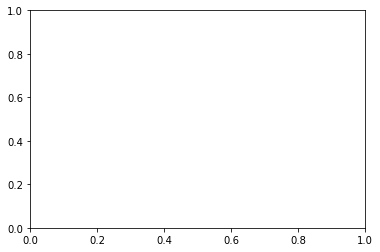

In [11]:
# Visualize footsteps
#for x in range(X_motion_step.shape[0]):        
while True:
    x = np.random.randint(0, X_motion_step.shape[0])
    print(X_motion_step[x, :2].tolist() + [X_motion_step[x, 5]], X_motion_step[x, 24:26])
    
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    
    # Starting posiitons
    fl_x = X_motion_step[x, 12]
    fl_y = X_motion_step[x, 13]
    fr_x = X_motion_step[x, 15]
    fr_y = X_motion_step[x, 16]
    rl_x = X_motion_step[x, 18]
    rl_y = X_motion_step[x, 19]
    rr_x = X_motion_step[x, 21]
    rr_y = X_motion_step[x, 22]

    # Inputs 3D positions        
    xs_input = np.array([fl_x, fr_x, rl_x, rr_x] ,dtype=object)
    ys_input = np.array([fl_y, fr_y, rl_y, rr_y] ,dtype=object)
    
    # Footstep sizes (predictions)
    fl_predicted_movement_x = 0
    fl_predicted_movement_y = 0
    fr_predicted_movement_x = 0 
    fr_predicted_movement_y = 0
    rl_predicted_movement_x = 0 
    rl_predicted_movement_y = 0
    rr_predicted_movement_x = 0 
    rr_predicted_movement_y = 0
    
    # Footstep sizes (targets)
    fl_target_movement_x = Y_motion_step[x, 0]
    fl_target_movement_y = Y_motion_step[x, 1]
    fr_target_movement_x = Y_motion_step[x, 2]
    fr_target_movement_y = Y_motion_step[x, 3]
    rl_target_movement_x = Y_motion_step[x, 4]
    rl_target_movement_y = Y_motion_step[x, 5]
    rr_target_movement_x = Y_motion_step[x, 6]
    rr_target_movement_y = Y_motion_step[x, 7]
    
    # CoM
    prev_com = [0, 0]
    curr_com = [0, 0]
    target_com = [0, 0]
    predicted_com = [0, 0]
    
    # FR and RL moving
    if X_motion_step[x, 24]:
        input_fr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fr_x]).reshape(-1, 1).T
        print(input_fr_x.shape)
        fr_predicted_movement_x = model_fr_x.predict(input_fr_x)
        
        input_fr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_y, fr_y]).reshape(-1, 1).T
        fr_predicted_movement_y = model_fr_y.predict(input_fr_y)
        
        input_rl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], rl_x, rr_x]).reshape(-1, 1).T
        rl_predicted_movement_x = model_rl_x.predict(input_rl_x)
        
        input_rl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], rl_y, rr_y]).reshape(-1, 1).T
        rl_predicted_movement_y = model_rl_y.predict(input_rl_y)
        
        input_com_fr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[0] = model_fr_com_x.predict(input_com_fr_x)
        
        input_com_fr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[1] = model_fr_com_y.predict(input_com_fr_y)
        
        point1 = [fr_x + fr_predicted_movement_x, fr_y + fr_predicted_movement_y]
        point2 = [rl_x + rl_predicted_movement_x, rl_y + rl_predicted_movement_y]
        prev_com[0] = (fr_x + rl_x) / 2
        prev_com[1] = (fr_y + rl_y) / 2
        curr_com[0] = (point1[0] + point2[0]) / 2
        curr_com[1] = (point1[1] + point2[1]) / 2
        target_com[0] = (fr_x + fr_target_movement_x + rl_x + rl_target_movement_x) / 2
        target_com[1] = (fr_y + fr_target_movement_y + rl_y + rl_target_movement_y) / 2
    # FL and RR moving
    else:
        input_fl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fr_x]).reshape(-1, 1).T
        fl_predicted_movement_x = model_fl_x.predict(input_fl_x)
        
        input_fl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_y, fr_y]).reshape(-1, 1).T
        fl_predicted_movement_y = model_fl_y.predict(input_fl_y)
        
        input_rr_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], rl_x, rr_x]).reshape(-1, 1).T
        rr_predicted_movement_x = model_rr_x.predict(input_rr_x)
        
        input_rr_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], rl_y, rr_y]).reshape(-1, 1).T
        rr_predicted_movement_y = model_rr_y.predict(input_rr_y)
        
        input_com_fl_x = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[0] = model_fl_com_x.predict(input_com_fl_x)
        
        input_com_fl_y = np.array([X_motion_step[x, 0], X_motion_step[x, 1], X_motion_step[x, 5], fl_x, fl_y, fr_x, fr_y, rl_x, rl_y, rr_x, rr_y]).reshape(-1, 1).T
        predicted_com[1] = model_fl_com_y.predict(input_com_fl_y)
        
        point1 = [fl_x + fl_predicted_movement_x, fl_y + fl_predicted_movement_y]
        point2 = [rr_x + rr_predicted_movement_x, rr_y + rr_predicted_movement_y]
        prev_com[0] = (fl_x + rr_x) / 2
        prev_com[1] = (fl_y + rr_y) / 2
        curr_com[0] = (point1[0] + point2[0]) / 2
        curr_com[1] = (point1[1] + point2[1]) / 2
        target_com[0] = (fl_x + fl_target_movement_x + rr_x + rr_target_movement_x) / 2
        target_com[1] = (fl_y + fl_target_movement_y + rr_y + rr_target_movement_y) / 2
        
    
    # Labels 3D positions        
    xs_targets = np.array([fl_x + fl_target_movement_x, fr_x + fr_target_movement_x, rl_x + rl_target_movement_x, rr_x + rr_target_movement_x] ,dtype=object)
    ys_targets = np.array([fl_y + fl_target_movement_y, fr_y + fr_target_movement_y, rl_y + rl_target_movement_y, rr_y + rr_target_movement_y] ,dtype=object)
    
    # Predictions 3D positions        
    xs_predictions = np.array([fl_x + fl_predicted_movement_x, fr_x + fr_predicted_movement_x, rl_x + rl_predicted_movement_x, rr_x + rr_predicted_movement_x] ,dtype=object)
    ys_predictions = np.array([fl_y + fl_predicted_movement_y, fr_y + fr_predicted_movement_y, rl_y + rl_predicted_movement_y, rr_y + rr_predicted_movement_y] ,dtype=object)

    ax1.scatter(xs_input, ys_input, marker='o', label="Starting Config.")
    ax1.scatter(xs_targets, ys_targets, marker='s', label="Target Config.")
    ax1.scatter(xs_predictions, ys_predictions, marker='x', label="Predicted Config.")
    #ax1.scatter(curr_com[0], curr_com[1], marker='^', c='b', label="Predicted CoM")
    #ax1.scatter(prev_com[0], prev_com[1], marker='^', c= 'r', label="Prev CoM")
    #ax1.scatter(target_com[0], target_com[1], marker='^', c= 'g', label="Target CoM")
    ax1.scatter(predicted_com[0], predicted_com[1], marker='^', c= 'g', label="Predicted CoM")
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    plt.show()